Target dataset: 

transaction = {
    time uint32
    size uint32  => n_inputs * IN_MEAN_SIZE + n_outputs * OUT_MEAN_SIZE + sum(map(out, scr_size))
    fee  uint32
}


In [1]:
import pandas as pd
# mapAddr2Ids = pd.read_csv("data/mapAddr2Ids.csv")

In [3]:
outputs_cname = [
                 "txID", 
                 "position", 
                 "addressID",
                 "amount",
                 "scriptType"
               ]

outputs_dtype_spec = {
    outputs_cname[0]: "uint32",   
    outputs_cname[1]: "uint32",
    outputs_cname[2]: "uint32",
    outputs_cname[3]: "uint32",
    outputs_cname[4]: "uint8",
}

outputs = pd.read_csv("data/outputs.csv", 
                        usecols=[0, 2, 4],
                        header=None, 
                        names=outputs_cname, 
                        dtype=outputs_dtype_spec,
                        index_col=outputs_cname[0]
                    )

In [4]:
script_size_mapping = {1: 153, 2: 180, 3: 291}
outputs['size'] = outputs['scriptType'].map(script_size_mapping).fillna(0)

In [5]:
output_size_count_df = outputs.groupby(level=0).agg(
    n_outputs=('size', 'size'),
    scripts_size=('size', 'sum')
)

In [6]:
inputs_cname = ["txID", 
                "prevTxID", 
                "prevTxPos"
               ]

inputs_dtype_spec = {
    inputs_cname[0]: "uint32",   
    inputs_cname[1]: "uint32",
    inputs_cname[2]: "uint32",
}

inputs = pd.read_csv("data/inputs.csv", 
                        usecols=[0],
                        header=None, 
                        names=inputs_cname, 
                        dtype=inputs_dtype_spec,
                        index_col=inputs_cname[0]
                    )

In [7]:
__input_grouped_by_index = inputs.index.value_counts()
input_count_df = pd.DataFrame({'n_inputs': __input_grouped_by_index})

In [8]:
tx_size_df = pd.merge(input_count_df, output_size_count_df, left_index=True, right_index=True, how="inner")

In [9]:
IN_MEAN_SIZE  = 9
OUT_MEAN_SIZE = 40

tx_size_df['size'] = IN_MEAN_SIZE * tx_size_df['n_inputs'] + OUT_MEAN_SIZE * tx_size_df['n_outputs'] + tx_size_df['scripts_size']
tx_size_df

n_inputs  n_outputs  scripts_size     size
txID                                               
7552999      1312          3         540.0  12468.0
60952         965          1         180.0   8905.0
121669        901          2         333.0   8522.0
92402         835          1         180.0   7735.0
93005         824          2         360.0   7856.0
...           ...        ...           ...      ...
4180697         1          2         360.0    449.0
4180696         1          2         360.0    449.0
4180695         1          2         360.0    449.0
4180694         1          2         360.0    449.0
5370299         1          2         360.0    449.0

[10358266 rows x 4 columns]

## Visualization

In [10]:
trans_cname = ["timestamp", "blockID", "txID", "isCoinbase", "fee"]
trans_dtype_spec = {
    "timestamp": "uint32",   
    "blockID": "uint32",
    "txID": "uint32",
    "isCoinbase": "bool",
    "fee": "uint32"
}

transactions = pd.read_csv("data/transactions.csv",
                               usecols=[0, 2, 3, 4],
                               header=None, 
                               names=trans_cname, 
                               dtype=trans_dtype_spec,
                               index_col=trans_cname[2],
                          )

In [11]:
non_mining_transactions = transactions[transactions['isCoinbase'] == False]
mining_transactions = transactions[transactions['isCoinbase'] == True]

In [12]:
transactions = transactions[['timestamp', 'fee']]

In [13]:
tx_size_fee = transactions.merge(tx_size_df[['size']], left_index=True, right_index=True)

In [14]:
tx_size_fee.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10358266 entries, 171 to 10572826
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  uint32 
 1   fee        uint32 
 2   size       float64
dtypes: float64(1), uint32(2)
memory usage: 197.6 MB


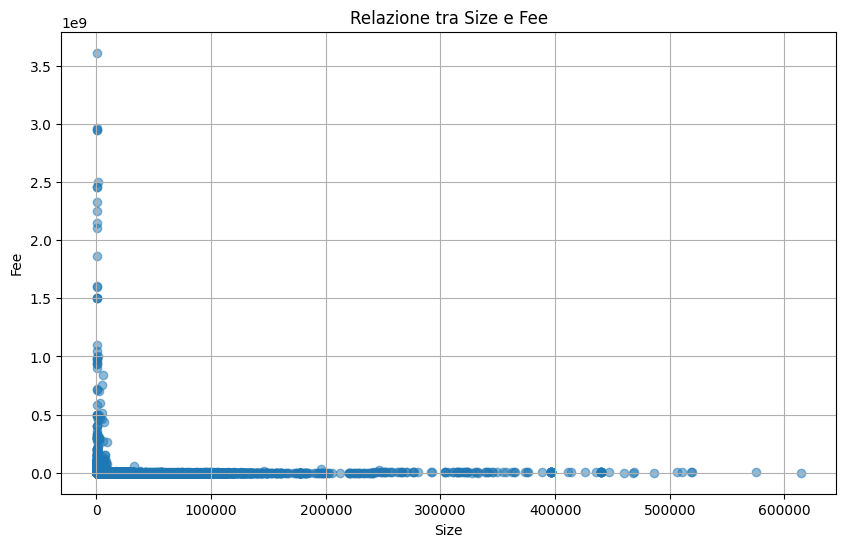

In [16]:
import matplotlib.pyplot as plt

# Supponendo che il tuo dataframe si chiami 'df'
# df = pd.read_csv('path_to_your_csv_file.csv') # Se stai leggendo da un file CSV

# Creazione del plot
plt.figure(figsize=(10, 6))
plt.scatter(tx_size_fee['size'], tx_size_fee['fee'], alpha=0.5)
plt.title('Relazione tra Size e Fee')
plt.xlabel('Size')
plt.ylabel('Fee')
plt.grid(True)
plt.show()

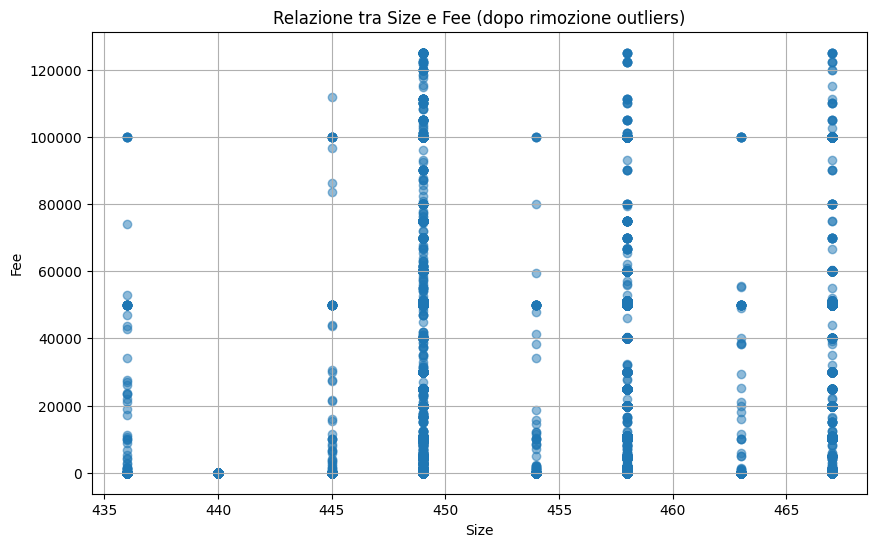

In [17]:
 # Calcolo dell'IQR
df = tx_size_fee

Q1_size = df['size'].quantile(0.25)
Q3_size = df['size'].quantile(0.75)
IQR_size = Q3_size - Q1_size

Q1_fee = df['fee'].quantile(0.25)
Q3_fee = df['fee'].quantile(0.75)
IQR_fee = Q3_fee - Q1_fee

# Filtraggio dei dati
df_filtered = df[~((df['size'] < (Q1_size - 1.5 * IQR_size)) | (df['size'] > (Q3_size + 1.5 * IQR_size)) |
                   (df['fee'] < (Q1_fee - 1.5 * IQR_fee)) | (df['fee'] > (Q3_fee + 1.5 * IQR_fee)))]

# Creazione del plot con i dati filtrati
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['size'], df_filtered['fee'], alpha=0.5)
plt.title('Relazione tra Size e Fee (dopo rimozione outliers)')
plt.xlabel('Size')
plt.ylabel('Fee')
plt.grid(True)
plt.show()

In [18]:
tx_scripts = outputs.merge(transactions[["timestamp"]], left_index=True, right_index=True, how="inner")

In [19]:
tx_scripts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24613803 entries, 0 to 10572826
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   addressID   uint32 
 1   scriptType  uint8  
 2   size        float64
 3   timestamp   uint32 
dtypes: float64(1), uint32(2), uint8(1)
memory usage: 492.9 MB


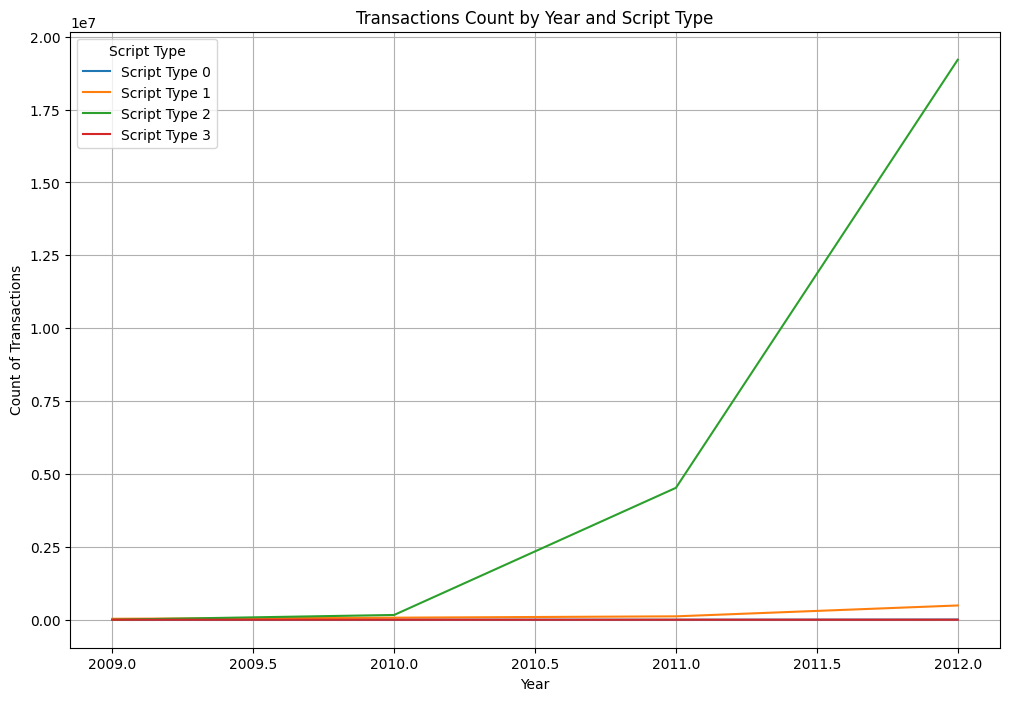

In [20]:
df = tx_scripts
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['timestamp'].dt.year

# Group by 'year' and 'scriptType' and count the transactions
grouped_df = df.groupby(['year', 'scriptType']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 8))
for script_type in grouped_df.columns:
    plt.plot(grouped_df.index, grouped_df[script_type], label=f'Script Type {script_type}')

plt.xlabel('Year')
plt.ylabel('Count of Transactions')
plt.title('Transactions Count by Year and Script Type')
plt.legend(title='Script Type')
plt.grid(True)
plt.show()

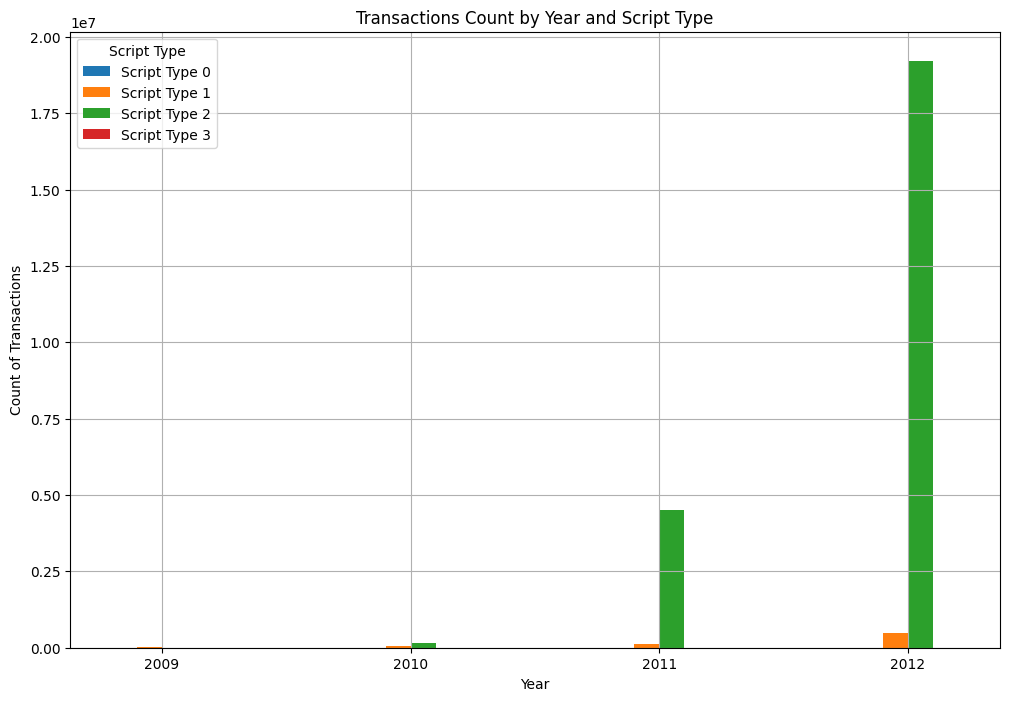

In [21]:
# Assume 'df' is your DataFrame
# Convert 'timestamp' from uint32 to datetime and extract the year
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['timestamp'].dt.year

# Group by 'year' and 'scriptType' and count the transactions
grouped_df = df.groupby(['year', 'scriptType']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define width of a single bar
bar_width = 0.1

# Get the list of years and script types
years = grouped_df.index
script_types = grouped_df.columns

# Plot each script type as a bar
for i, script_type in enumerate(script_types):
    ax.bar(
        years + i * bar_width,  # Adjust the position for each script type
        grouped_df[script_type],
        width=bar_width,
        label=f'Script Type {script_type}'
    )

# Set x-ticks to be at the center of the grouped bars
ax.set_xticks(years + bar_width * (len(script_types) - 1) / 2)
ax.set_xticklabels(years)

plt.xlabel('Year')
plt.ylabel('Count of Transactions')
plt.title('Transactions Count by Year and Script Type')
plt.legend(title='Script Type')
plt.grid(True)
plt.show()

In [22]:
addr_map_cname = [
                    "address", 
                    "addressID", 
                 ]

addr_map_dtype_spec = {
    addr_map_cname[0]: "string",   
    addr_map_cname[1]: "int32",
}

addr_map = pd.read_csv("data/mapAddr2Ids.csv", 
                        # usecols=[0, 4],
                        header=None, 
                        names=addr_map_cname, 
                        dtype=addr_map_dtype_spec,
                        index_col=addr_map_cname[1]
                    )
addr_map.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8708821 entries, 0 to 8708820
Data columns (total 1 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   address  string
dtypes: string(1)
memory usage: 99.7 MB


In [23]:
miner_outputs = mining_transactions.merge(outputs, left_index=True,right_index=True, how="inner")

In [24]:
miner_ids = miner_outputs.reset_index()['addressID'].drop_duplicates()
miner_ids_df = pd.DataFrame(miner_ids, columns=['addressID'])

assert(miner_ids.count() == miner_ids_df['addressID'].count())

# Step 2: Filter addr_map to keep only the rows where the index is in miner_ids
miner_addr_map = addr_map[addr_map.index.isin(miner_ids)]
assert(miner_addr_map['address'].count() == miner_ids.count())

In [25]:
miner_addr_map

address
addressID                                    
0          1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1          12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2          1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3          1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4          15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG
...                                       ...
8707816    12uTvB3SRh4p6ytc45xxVYe6S12rCBf1E6
8708320                                 #5893
8708330    1JkTWpeJUwu9Mbhpk2EyF8Kh2J77bFab1p
8708362    1FeKwcQ4o5Eh7nsRDdG6jx8ysGzgBSij4S
8708625    1GTHhYUAtMjNKUPWxvxfGHptZchKvWGaUs

[202397 rows x 1 columns]

In [10]:
import requests
import re
from bs4 import BeautifulSoup 
from fp.fp import FreeProxy


BASE_URL="http://www.walletexplorer.com"

In [4]:
cache = {}

In [33]:
from io import StringIO
proxy_source = 'https://free-proxy-list.net/'
res = requests.get(proxy_source)
assert(res.status_code == 200)

bs_page = BeautifulSoup(res.content, 'html.parser')
bs_table = bs_page.find('table')

proxy_df = pd.read_html(StringIO(str(bs_table)))[0]
proxy_df = proxy_df[['IP Address', 'Port', 'Https']]
proxy_df.rename(columns={'IP Address': 'Ip'}, inplace=True)
# proxy_df=proxy_df[proxy_df['Https'] == 'yes']
print(proxy_df)
proxy_df=proxy_df[:30]

                 Ip   Port Https
0     116.203.28.43     80    no
1       51.89.14.70     80    no
2    20.206.106.192   8123    no
3    50.223.239.194     80    no
4    50.223.239.190     80    no
..              ...    ...   ...
295  207.138.39.145    999    no
296   85.117.60.131   8080    no
297    34.92.250.88  11111   yes
298   50.207.199.83     80    no
299   50.222.245.45     80    no

[300 rows x 3 columns]


In [42]:
from datetime import timedelta, datetime

PROXY_THRESHOLD = timedelta(seconds=1)

async def eval(addr):
    eval_threshold=0.5
    failed = False
    init = datetime.now()
    try:
        print(addr)
        # res = requests.get(BASE_URL, timeout=eval_threshold, proxies={'http': addr, 'https': addr})
        res = requests.get(BASE_URL, proxies={'http': addr, 'https': addr})
    except Exception as e:
        print(e)
        failed = True
    done = datetime.now()

    if failed: 
        return -4
        
    if res.status_code != 200:
        return -1

    if  "<html" not in res.text:
        return -2
        
    return done - init

proxy_df['Port']    = proxy_df['Port'].astype(str)
proxy_df['latency'] = "http://" + proxy_df['Ip'] + ":" + proxy_df['Port']
proxy_df['latency'] = proxy_df['latency'].map(eval)

for i, row in proxy_df.iterrows():
    proxy_df.at[i,'latency'] =  await row['latency']

# proxy_df = proxy_df[proxy_df['latency'] != None]
# proxy_df = proxy_df.sort_values(by='latency', ascending=True)
proxy_df

http://116.203.28.43:80
HTTPSConnectionPool(host='www.walletexplorer.com', port=443): Max retries exceeded with url: / (Caused by ProxyError('Unable to connect to proxy', OSError('Tunnel connection failed: 301 Moved Permanently')))
http://51.89.14.70:80
HTTPSConnectionPool(host='www.walletexplorer.com', port=443): Max retries exceeded with url: / (Caused by ProxyError('Unable to connect to proxy', OSError('Tunnel connection failed: 404 Not Found')))
http://20.206.106.192:8123
http://50.223.239.194:80
HTTPConnectionPool(host='50.223.239.194', port=80): Max retries exceeded with url: http://www.walletexplorer.com/ (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x145a14890>, 'Connection to 50.223.239.194 timed out. (connect timeout=None)')))
http://50.223.239.190:80
HTTPConnectionPool(host='50.223.239.190', port=80): Max retries exceeded with url: http://www.walletexplorer.com/ (Caused by ProxyError('Unable to connect t

Ip   Port Https         latency
0     116.203.28.43     80    no              -4
1       51.89.14.70     80    no              -4
2    20.206.106.192   8123    no              -1
3    50.223.239.194     80    no              -4
4    50.223.239.190     80    no              -4
5     176.65.240.15     80    no              -4
6   213.218.228.253     80    no              -4
7     51.210.127.15     80    no              -4
8   190.103.177.131     80    no              -4
9     50.169.135.10     80    no              -4
10   209.146.104.56     80    no              -4
11   50.223.239.191     80    no              -4
12    62.99.138.162     80    no              -4
13    192.73.244.36     80    no              -4
14    50.222.245.42     80    no              -4
15    89.145.162.81   3128    no              -4
16   155.94.241.132   3128    no              -4
17    67.43.227.227  17629   yes              -4
18     72.10.160.92  27103   yes              -4
19    172.183.241.1   8080   yes              -4
20    67.43.228.251   2081   yes              -4
21    43.133.59.220   3128   yes  0:00:17.702970
22  223.135.156.183   8080   yes              -1
23     148.72.165.7  10529   yes              -4
24    72.10.160.172  16679   yes              -4
25    67.43.228.254  10909   yes              -4
26  134.209.144.177     80   yes              -4
27   185.217.136.67   1337   yes              -4
28    72.10.160.171  24049   yes              -4
29    51.210.19.141     80    no              -4

In [19]:
# PROXY_THRESHOLD = timedelta(seconds=0.2)

# proxy_df[proxy_df['latency'] < PROXY_THRESHOLD]

In [9]:
curr_proxy = 0
banned = []

def get_next_proxy():
    global curr_proxy, proxy_df, banned

    idx = curr_proxy
    curr_proxy = (curr_proxy + 1) % len(proxy_df)
    sp = proxy_df.iloc[idx]

    url = f"http://{sp['Ip']}:{sp['Port']}"

    if url in banned:
        return get_next_proxy()
    
    return {
        'http': url,
        'https': url,
    }

def get_html(url, **kwargs):
    global banned, proxy_df
    p = get_next_proxy()
    try:
        response = requests.get(url, proxies=p, timeout=0.5, **kwargs)
        if response.status_code == 429:
            print("Too many req...")
            return get_html(url, **kwargs)
            
        response.raise_for_status()

        if  "<html" not in response.text:
            print(response.text)
            raise Exception("Invalid proxy.")
        
        return response
    
    except:
        banned.append(p['http'])
        print("Remainings proxy", len(proxy_df) - len(banned))
        return get_html(url, **kwargs)


get_html(BASE_URL)

Remainings proxy 29
Remainings proxy 28
Remainings proxy 27
Remainings proxy 26
Remainings proxy 25
Remainings proxy 24
Remainings proxy 23
Remainings proxy 22
Remainings proxy 21


<Response [200]>

In [37]:
def get_page_number(soup, res): 
    paging_container = soup.find('div', class_='paging')
    if not paging_container:
        print(res)
    assert(paging_container)

    paging_text = paging_container.text.strip()
    match = re.search(r'Page (\d+) \/ (\d+)', paging_text)
    assert(match)
    
    total_pages = match.group(2)
    return int(total_pages)

def cache_wallet_addr(wallet):
    global cache
    
    curr_page = 0;
    page_number = 1;

    while curr_page < page_number: 
        curr_page += 1
        response = get_html(f"{BASE_URL}/wallet/{wallet}/addresses")
        soup = BeautifulSoup(response.content, 'html.parser')

        if curr_page == 1:
            page_number = get_page_number(soup, response)
        
        links = soup.find_all('a', href=lambda href: href and href.startswith('/address/'))    
        assert(links and len(links) > 0)

        for link in links: 
            addr = link['href'][9:]
            cache[addr]=wallet

def get_addr_wallet(addr):
    global cache
    if addr in cache:
        return cache[addr]

    response = get_html(f"{BASE_URL}/address/{addr}")
    print(response.content)
    
    soup = BeautifulSoup(response.content, 'html.parser')
   
    walletnote_div = soup.find('div', class_='walletnote')
    assert(walletnote_div)
    link = walletnote_div.find('a', href=lambda href: href and href.startswith('/wallet/'))    
    assert(link)
    link_url = link['href']
    wallet = link_url[8:]
    assert(len(wallet) > 0)
    
    # cache_wallet_addr(wallet)
    return wallet


get_addr_wallet("1k1Z6X48AuHYus6io5KkEVryQm5jMiDRK")

Remainings proxy 29
Remainings proxy 28
Remainings proxy 27
Remainings proxy 26
Remainings proxy 25
Remainings proxy 24
Remainings proxy 23
Remainings proxy 22
Remainings proxy 21
Remainings proxy 20
Remainings proxy 19
Remainings proxy 18
Remainings proxy 17
Remainings proxy 16
Remainings proxy 15
Remainings proxy 14
Remainings proxy 13
Remainings proxy 12
Remainings proxy 11
Remainings proxy 10
Remainings proxy 9
Remainings proxy 8
Remainings proxy 7
Remainings proxy 6
Remainings proxy 5
Remainings proxy 4
Remainings proxy 3
Remainings proxy 2
Remainings proxy 1
Remainings proxy 0


RecursionError: maximum recursion depth exceeded

In [50]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def map_wrapper(args):
    chunk, column, map_func = args
    return chunk[column].map(map_func)

def parallel_map(df, column, map_func, num_threads=None):
    if num_threads is None:
        num_threads = min(cpu_count(), 32)  # Limiting to a reasonable number of threads

    chunk_size = len(df) // num_threads
    chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(map_wrapper, (chunk, column, map_func)) for chunk in chunks]

    results = [future.result() for future in as_completed(futures)]
    result_series = pd.concat(results)

    return result_series



In [53]:
cache = {}

limited = miner_addr_map.head(30).copy()

limited['wallet'] = limited['address']

# limited['wallet'] = parallelize_dataframe(limited['wallet'], process_chunk)

res = parallel_map(limited, 'wallet', get_addr_wallet)
# limited['wallet'] = limited['wallet'].map(get_addr_wallet)
# print(len(proxys))

00
0

0
0
0
0
0


KeyboardInterrupt: 

0


In [115]:
proxy = 'http://35.185.196.38:3128'
# proxy = 'http://185.217.136.67:1337'

# proxy = 'http://13.37.59.99:3128'


headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

proxies = {'http': proxy, 'https': proxy}
# res = requests.get('http://ipinfo.io/json', proxies=proxies)
res = requests.get('https://www.walletexplorer.com', proxies=proxies, headers=headers, verify=False)
print(res.headers)
print(res.content)

/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '35.185.196.38'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'Date': 'Wed, 12 Jun 2024 20:26:08 GMT', 'Server': 'Apache/2.4.38 (Debian)', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Content-Length': '4616', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Content-Type': 'text/html; charset=UTF-8'}
b'<!DOCTYPE html>\n<html lang="en">\n<meta charset="utf-8"/>\n<title>WalletExplorer.com: smart Bitcoin block explorer</title>\n<link href="/styles.css" rel="stylesheet">\n<meta name="referrer" content="always">\n\n<div id="topbar">\n <h1><a href="/">WalletExplorer.com</a>: smart Bitcoin block explorer</h1>\n <form action="/">\n  <input type="text" name="q" value=""/>\n  <input type="submit" value="Search address/txid/wallet id/xpub/firstbits"/> </form>\n</div>\n\n<div id="main">\n<h2 class="main">Bitcoin block explorer with address grouping and wallet labeling</h2><form action="/" class="main"><p><label>Enter address, txid, <a href="https://en.bitcoin.it/wiki/Firstbits">firstbits</a> (first address characters), first txid c